# Donald-Harris Debate

Here, we'll have a little kick-around of the "Harris vs. Trump" debate of the 2024 elections.
I got the [data here](https://github.com/jumonlala/harris_trump_debate/).

In [4]:
from graze import graze
import pandas as pd
import io

src_url = 'https://raw.githubusercontent.com/jumonlala/harris_trump_debate/refs/heads/main/data/harris_trump.csv'

data = pd.read_csv(io.BytesIO(graze(src_url)), index_col=0)

print(f"{data.shape=}")

harris_text = '\n\n'.join(data[data.speaker=='KAMALA HARRIS'].text).lower()
trump_text = '\n\n'.join(data[data.speaker=='DONALD TRUMP'].text).lower()

print(f"{len(harris_text)=}")
print(f"{len(trump_text)=}")

data.head()


data.shape=(1141, 8)
len(harris_text)=32852
len(trump_text)=43332


,id,speaker,text,topic,token,polarity,subjectivity,certainty
0,14,KAMALA HARRIS,"So, I was raised as a middle-class kid",economy,"['so', 'be', 'raise', 'a', 'middle-class', 'kid']",0.00,0.000000,1.00
1,16,DONALD TRUMP,"First of all, I have no sales tax",economy,"['first', 'all', 'have', 'no', 'sale', 'tax']",0.25,0.333333,1.00
2,18,KAMALA HARRIS,"Well, I would love to",economy,"['well', 'would', 'love']",0.50,0.600000,-0.50
3,20,DONALD TRUMP,"Number one, I have nothing to do, as you know ...",economy,"['number', 'one', 'have', 'nothing', 'do', 'kn...",0.50,0.500000,0.75
4,22,KAMALA HARRIS,"So, Donald Trump has no plan for you",economy,"['so', 'donald', 'tramp', 'have', 'no', 'plan']",0.00,0.000000,1.00


## They're eating the dogs

Just to verify something I know should be there, is there...

In [5]:
next(filter(lambda x: "they're eating the dogs" in x, data.text))

"In Springfield, they're eating the dogs"

## Aggregating text; harris and trump separately

In [6]:
from guise import word_cloud_store

text_store = {
    'harris': harris_text,
    'trump': trump_text
}

word_clouds = word_cloud_store(text_store)

list(word_clouds)

['harris', 'trump']

## Talking about the other

The whole raison d'être of this data stroll was to look into the claims made in the ["Cold Case Solved"](https://medium.com/@alterfero/cold-case-solved-the-silent-38-0-victory-in-the-2024-debate-464053a5ecd9), which I encourage you to read. 
It's a linguists analysis of the word frequencies of the debate, based on [this msn transcript](https://www.msn.com/en-us/news/politics/read-harris-trump-presidential-debate-transcript/ar-AA1qmevU) of the debate (I mention this, because, as you'll notice, our numbers are a bit off, but the overall observation is the same):

In [7]:
print(f"Harris mentions 'Donald' {sum(word == 'donald' for word in harris_text.split())} times")
print(f"Harris mentions 'Trump' {sum(word == 'trump' for word in harris_text.split())} times")
print("... and on the other hand,")
print(f"Trump mentions 'Kamala' {sum(word == 'kamala' for word in trump_text.split())} times")
print(f"Trump mentions 'Harris' {sum(word == 'harris' for word in trump_text.split())} times")

Harris mentions 'Donald' 32 times
Harris mentions 'Trump' 30 times
... and on the other hand,
Trump mentions 'Kamala' 0 times
Trump mentions 'Harris' 0 times


## Word clouds, using word count for size

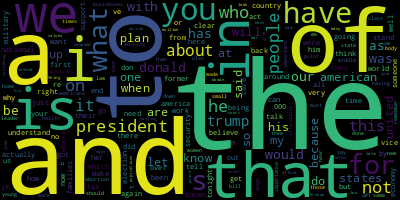

In [8]:
word_clouds['harris']

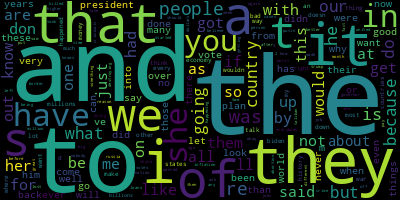

In [9]:
word_clouds['trump']

## Discounting commong words

These word count clouds are a bit boring. Most of the visual space is taken by very common words that have no real informational content. 

Let's start with a conservative set of stop words.

In [54]:
stopwords = {'the', 'and', 'is', 'that', 'they', 'of', 'a', 'to', 'it', 'its', 's'}
word_clouds_with_a_few_stopwords = word_cloud_store(text_store, stopwords=stopwords)

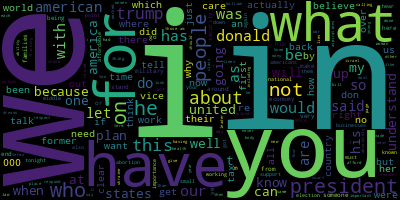

In [ ]:
word_clouds_with_a_few_stopwords['harris']

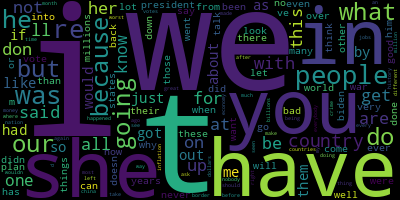

In [45]:
word_clouds_with_a_few_stopwords['trump']

In [48]:
from guise import STOPWORDS  # is just taken from wordcloud.STOPWORDS
print(f"Using {len(STOPWORDS)} stopwords")
word_clouds_with_192_stopwords = word_cloud_store(text_store, stopwords=STOPWORDS)

Using 192 stopwords


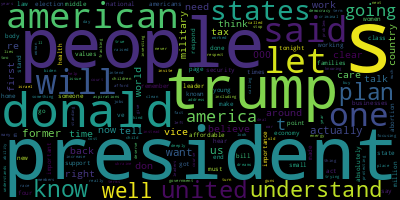

In [49]:
word_clouds_with_192_stopwords['harris']

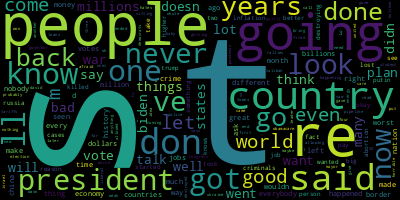

In [50]:
word_clouds_with_192_stopwords['trump']

## Weighing words against "normal" usage

You might be thinking "but how common should a word be to be considered a stopword?".
You might be thinking "isn't the stopword method a bit black-and-white? Shouldn't I instead 
be able to discount a word more or less, according to how common it is?".
If you're thinking that, you're smart. 
Or you're cheating and just know about natural language processing (NLP).  

Indeed, one common approach is to use a list of stopwords, but also to discount words 
according to their frequency in some large corpus of text (representing "normal usage in the context"). 
That is, we want to weigh UP words according to how often a particular speaker (or source of words) uses them, 
but also weigh DOWN words according to how common they are in general (or in the particular context).

This is often referred to as "term frequency-inverse document frequency" (TF-IDF).
The TF is the weighing up part, and the IDF is the weighing down part.

Now, we won't exactly do that here, but something similar. 
We'll take the "general English" word frequencies to weigh down words.


`guise` gives you access to the general English word count, computed over a very large corpus. 

The first time you use it, it will download the csv from a repository github, and cache it locally 
so you don't need to be online there after. 

In [ ]:
from guise import english_word_frequencies
from collections import Counter
import pandas as pd

en_word_freq = english_word_frequencies()
print(f"{en_word_freq.shape=}")


en_word_freq.shape=(333331,)


Now let's make word clouds, using a small stopwords set, along with the general english 
word counts as a reference to weigh the speakers own word counts against.
`word_cloud` and `word_cloud_store` have a `words_to_weights` parameter that we'll use here. 
We'll use the convenient `TFIDFCalculator` tool to make a `words_to_weights` based on our stop words 
and reference corpus.

In [55]:
from guise import word_cloud_store
from guise import TFIDFCalculator

words_to_weights = TFIDFCalculator(
    reference_corpus=en_word_freq,
    stopwords={'the', 'and', 'is', 'that', 'they', 'of', 'a', 'to', 'it', 'its', 's'},
    custom_idf=['trump', 'harris']  # words to put on equal footing (give it the same default idf weight, because trump means something else)
)
word_clouds = word_cloud_store(text_store, words_to_weights=words_to_weights)

list(word_clouds)

['harris', 'trump']

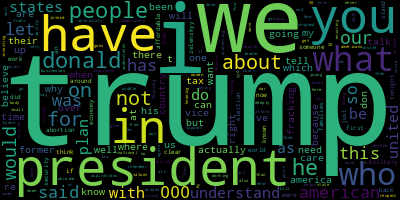

In [56]:
word_clouds['harris']

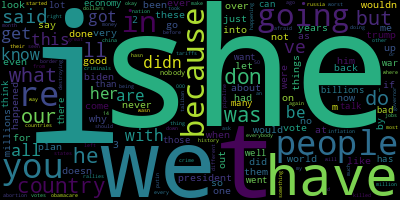

In [57]:
word_clouds['trump']